In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Model building
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

# Import custom scripts
from data_preparation import load_data, clean_data
from feature_engineering import create_features

# Setup
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [2]:
# --- 2. Full Data Processing Pipeline ---
print("--- Running Full Data Processing Pipeline ---")
df_raw = load_data('diabetes_readmission.csv')
df_clean = clean_data(df_raw.copy())
df_final = create_features(df_clean.copy())
print("Pipeline complete. Final data shape:", df_final.shape)

--- Running Full Data Processing Pipeline ---
Loading data...
Data loaded successfully.
Cleaning data...
Data shape after cleaning: (101763, 43)
Data cleaning complete.
Starting feature engineering...
Engineering diagnosis features...
Engineering age feature...
Engineering medication features...
Engineering service utilization feature...
One-hot encoding categorical features...
Feature engineering complete.
Pipeline complete. Final data shape: (101763, 122)


In [4]:
# Split data into training and testing sets
# Prepare features and target
X = df_final.drop(columns=['readmitted'])
y = df_final['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
# Identify numerical columns in the final dataframe (they don't have '_' in their name, a simple heuristic here)
numerical_cols = [c for c in X_train.columns if X_train[c].dtype != 'uint8' and c != 'age']
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (81410, 121)
Test set shape: (20353, 121)


In [5]:
# --- 4. Define and Train Stacked Ensemble Model ---
print("\n--- Building and Training Stacked Model ---")

# Define base models with some initial good parameters
base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)),
    ('xgb', XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)),
    ('lgbm', LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1))
]

# Define the meta-classifier
meta_classifier = LogisticRegression(solver='liblinear')

# Create the stacking classifier
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_classifier,
    cv=5, # Use 5-fold cross-validation on the training data for the base models
    n_jobs=-1
)


--- Building and Training Stacked Model ---


In [6]:
# Train the model
stacking_clf.fit(X_train, y_train)
print("Model training complete.")

# --- 5. Evaluate the Model ---
print("\n--- Evaluating Model Performance ---")
y_pred = stacking_clf.predict(X_test)
y_proba = stacking_clf.predict_proba(X_test)[:, 1]

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Accuracy
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")

Model training complete.

--- Evaluating Model Performance ---
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18082
           1       0.56      0.03      0.06      2271

    accuracy                           0.89     20353
   macro avg       0.72      0.51      0.50     20353
weighted avg       0.85      0.89      0.84     20353

Accuracy Score: 0.8891


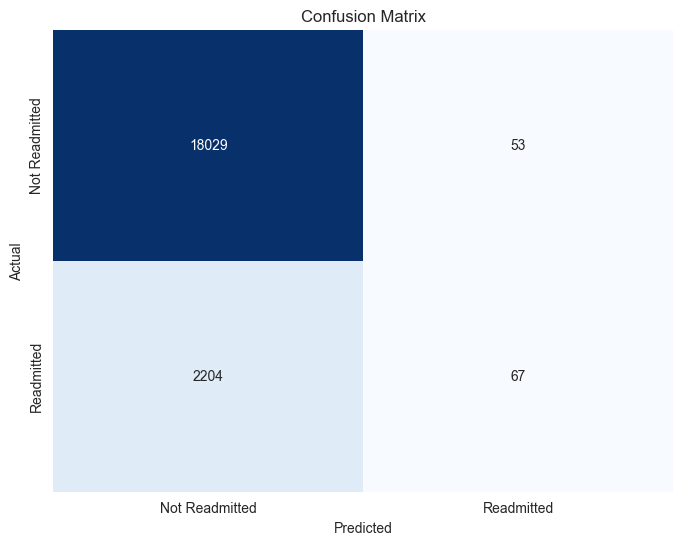

In [7]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [8]:
# --- 6. Full Hyperparameter Tuning ---
print("\n--- Starting Full Hyperparameter Tuning for Base Models ---")
# NOTE: This process is computationally expensive and may take several minutes to complete.

# --- 6.1 Tuning RandomForestClassifier ---
print("\n[1/3] Tuning RandomForestClassifier...")
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_leaf': [2, 5]
}
rf_tuner = GridSearchCV(estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
                        param_grid=param_grid_rf,
                        cv=3, n_jobs=-1, verbose=1, scoring='roc_auc')

rf_tuner.fit(X_train, y_train)
print(f"Best parameters for RandomForest: {rf_tuner.best_params_}")
best_rf = rf_tuner.best_estimator_

# --- 6.2 Tuning XGBClassifier ---
print("\n[2/3] Tuning XGBClassifier...")
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
xgb_tuner = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1),
                         param_grid=param_grid_xgb,
                         cv=3, n_jobs=-1, verbose=1, scoring='roc_auc')

xgb_tuner.fit(X_train, y_train)
print(f"Best parameters for XGBoost: {xgb_tuner.best_params_}")
best_xgb = xgb_tuner.best_estimator_

# --- 6.3 Tuning LGBMClassifier ---
print("\n[3/3] Tuning LGBMClassifier...")
param_grid_lgbm = {
    'n_estimators': [100, 200],
    'num_leaves': [31, 50],
    'learning_rate': [0.05, 0.1]
}
lgbm_tuner = GridSearchCV(estimator=LGBMClassifier(random_state=42, n_jobs=-1),
                          param_grid=param_grid_lgbm,
                          cv=3, n_jobs=-1, verbose=1, scoring='roc_auc')

lgbm_tuner.fit(X_train, y_train)
print(f"Best parameters for LightGBM: {lgbm_tuner.best_params_}")
best_lgbm = lgbm_tuner.best_estimator_

print("\n--- Hyperparameter tuning complete for all base models. ---")


# --- 7. Training the Tuned Stacking Classifier ---
print("\n--- Building and Training the Final Tuned Stacking Model ---")

# Define the list of our newly tuned base models
tuned_estimators = [
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('lgbm', best_lgbm)
]

# Use the same meta-classifier
meta_classifier = LogisticRegression(solver='liblinear')

# Create the final, tuned stacking classifier
tuned_stacking_clf = StackingClassifier(
    estimators=tuned_estimators,
    final_estimator=meta_classifier,
    cv=5, # Use 5-fold cross-validation
    n_jobs=-1
)



--- Starting Full Hyperparameter Tuning for Base Models ---

[1/3] Tuning RandomForestClassifier...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters for RandomForest: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 200}

[2/3] Tuning XGBClassifier...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}

[3/3] Tuning LGBMClassifier...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Number of positive: 9086, number of negative: 72324
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train set: 81410, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg

In [9]:
# Train the final model
tuned_stacking_clf.fit(X_train, y_train)
print("Final tuned model training complete.")


# --- 8. Final Evaluation of Tuned Model ---
print("\n--- Evaluating Final Tuned Model Performance ---")
y_pred_tuned = tuned_stacking_clf.predict(X_test)
y_proba_tuned = tuned_stacking_clf.predict_proba(X_test)[:, 1]

# Print classification report
print("Tuned Model Classification Report:")
print(classification_report(y_test, y_pred_tuned))

# Accuracy
print(f"Tuned Model Accuracy Score: {accuracy_score(y_test, y_pred_tuned):.4f}")


Final tuned model training complete.

--- Evaluating Final Tuned Model Performance ---
Tuned Model Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18082
           1       0.60      0.03      0.06      2271

    accuracy                           0.89     20353
   macro avg       0.74      0.51      0.50     20353
weighted avg       0.86      0.89      0.84     20353

Tuned Model Accuracy Score: 0.8895


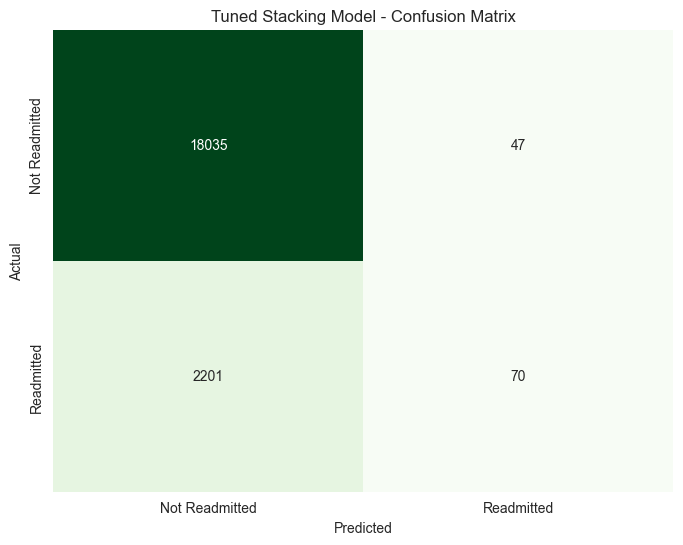

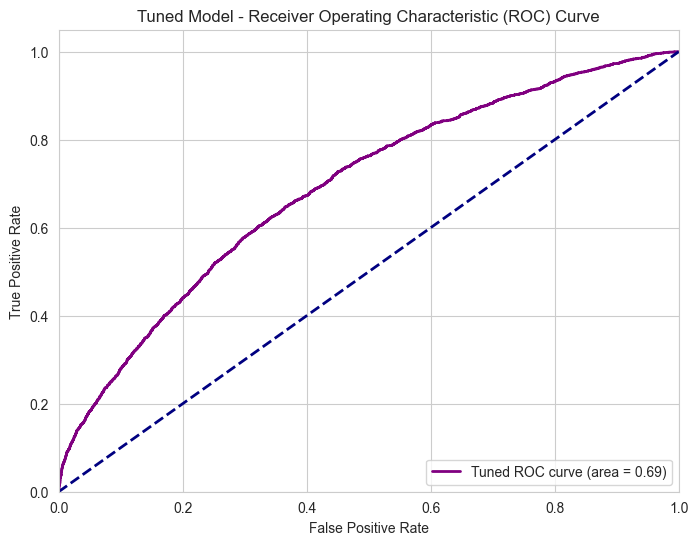

In [10]:
# Confusion Matrix for the tuned model
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'])
plt.title('Tuned Stacking Model - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC Curve and AUC for the tuned model
fpr_tuned, tpr_tuned, thresholds_tuned = roc_curve(y_test, y_proba_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

plt.figure(figsize=(8, 6))
plt.plot(fpr_tuned, tpr_tuned, color='purple', lw=2, label=f'Tuned ROC curve (area = {roc_auc_tuned:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned Model - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
